In [1]:
import pandas as pd

pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',200)

### Cargo Librerias y datasets

In [2]:
from pathlib import Path
import sys
from random import sample
from sklearn.model_selection import train_test_split
# sys.path.append('../data')
# sys.path.append('../')
sys.path.append('../../data')
sys.path.append('../../')
PATH = Path('../../data/')

In [3]:
from lib import transformers, data, mvp_budget_utils

In [407]:
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import math
import numpy as np

In [408]:
# si todo va bien lo sumamos a los transformers
from sklearn.base import BaseEstimator, TransformerMixin

class DirectorFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, min_cnt_movies=2):
        self.min_cnt_movies = min_cnt_movies

    def fit(self, X, y):
        # Esto no es la forma mas elegante, pero es mas comodo y a esta altura priorizo la comodidad
        # Llevamos las cosas de nuevo a un DataFrame y calculamos features por director
        directors_stats = (
            pd.DataFrame(X)
                .groupby('director')
                .agg({
                'tconst': 'count'                
                }
            )
        )

        # Para hacer flattening de las columnas
        # https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
        directors_stats.columns = [
            '_'.join(i)
            for i in zip(directors_stats.columns.get_level_values(1), directors_stats.columns.get_level_values(0))
        ]

        # Guardamos las estadisticas
        self.directors_stats_ = directors_stats

        # Diccionario con los datos para los directores comunes
        self.directors_stats_lk_ = (
            directors_stats[directors_stats.count_tconst >= self.min_cnt_movies].to_dict(orient='index')
        )

        # Valor default para los que consideramos que tenemos demasiado poca data
        self.default_ = directors_stats[directors_stats.count_tconst < self.min_cnt_movies].mean(0).to_dict()
        if self.min_cnt_movies > 1:
            self.default_ = directors_stats[directors_stats.count_tconst < self.min_cnt_movies].mean(0).to_dict()
        else:
            self.default_ = directors_stats.mean(0).to_dict()
        return self

    def transform(self, X):
        res = []
        for e in X:
            if e['director'] in self.directors_stats_lk_:
                res.append(self.directors_stats_lk_[e['director']])
            else:
                res.append(self.default_)
        return res

## Cargamos movies & movies gross
#### Movies lo cargamos para tener el ds a mano por si queremos agregar algo mas.

In [409]:
# Si quiero cargar todo
movies_full = data.load_data(PATH)

# Si quiero cargar solo budget con gross (data vieja)
movies_gross = data.load_movie_gross(PATH)

# cargo info de budget con el scrapper (data nueva)
imdb_scrapper_budget = data.imdb_scrapper(PATH)

Loading title basics...
Loading title ratings...
Loading movie directors...
Merging everything...
Dataset ya disponible


In [410]:
movies_full.head(2)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,director
0,tt0000502,movie,Bohemios,Bohemios,0,1905.0,\N,100.0,[no-genre],4.5,8,nm0063413
1,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906.0,\N,70.0,"[Biography, Crime, Drama]",6.1,613,nm0846879


In [411]:
imdb_scrapper_budget.head(4)

,tconst,budget,gross
0,tt0006864,"$385,907",NaN
1,tt0011549,"$100,000",NaN
2,tt0015624,"$245,000",NaN
3,tt0017136,"DEM6,000,000","$1,349,711"


In [412]:
movies_gross.head(2)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pirate|singapore,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0


In [413]:
# creamos variable tconst para poder matchear (si queremos) con movies
movies_gross['tconst']=movies_gross.movie_imdb_link.apply(lambda x: x.replace('http://www.imdb.com/title/','').replace('/?ref_=fn_tt_tt_1',''))

In [414]:
#Renombro columna de director y year
# Esto lo hago para usar las funciones de los transformers ... 
# Si vemos que tiene sentido y suma, hacemos nuestra propia funcion, por el momento es test
movies_gross['startYear'] = movies_gross['title_year']
movies_gross['director']  = movies_gross['director_name']

In [415]:
movies_gross.head(2)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,tconst,startYear,director
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,tt0499549,2009.0,James Cameron
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pirate|singapore,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,tt0449088,2007.0,Gore Verbinski


In [416]:
# Aca sumo load_data y mergeo con movies_gross
# movies_full = load_data()
# movies = movies_full.merge(movie_gross, on = 'tconst', how = 'inner')


In [417]:
# imdb_scrapper_budget = data.imdb_scrapper(PATH)

## Filtrmamos el ds

In [418]:
# Filtro columnas del df movie_gross y me quedo con las que pueden servir
df_movies_gross= movies_gross[['director', 'actor_1_name','actor_2_name', 'actor_3_name', 'genres', 'movie_title', 'movie_imdb_link', 'language', 'country',
                               'content_rating','plot_keywords', 'title_year', 'startYear',  'duration',
                  'num_critic_for_reviews', 'director_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users', 
                  'cast_total_facebook_likes','facenumber_in_poster', 'num_user_for_reviews', 'imdb_score', 'tconst', 'budget']]
df_movies_gross.head(2)

,director,actor_1_name,actor_2_name,actor_3_name,genres,movie_title,movie_imdb_link,language,country,content_rating,plot_keywords,title_year,startYear,duration,num_critic_for_reviews,director_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,tconst,budget
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action|Adventure|Fantasy|Sci-Fi,Avatar,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,English,USA,PG-13,avatar|future|marine|native|paraplegic,2009.0,2009.0,178.0,723.0,0.0,936.0,855.0,1000.0,886204,4834,0.0,3054.0,7.9,tt0499549,237000000.0
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,English,USA,PG-13,goddess|marriage ceremony|marriage proposal|pirate|singapore,2007.0,2007.0,169.0,302.0,563.0,5000.0,1000.0,40000.0,471220,48350,0.0,1238.0,7.1,tt0449088,300000000.0


In [419]:
def dividir(x):
    try:
        return x.split('|')
    except:
        return np.nan

In [420]:
df_movies_gross.genres=df_movies_gross.genres.apply(lambda x: x.split('|'))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [421]:
df_movies_gross.plot_keywords=df_movies_gross.plot_keywords.apply(dividir)

In [422]:
df_movies_gross.plot_keywords

0                                 [avatar, future, marine, native, paraplegic]
1           [goddess, marriage ceremony, marriage proposal, pirate, singapore]
2                                    [bomb, espionage, sequel, spy, terrorist]
3       [deception, imprisonment, lawlessness, police officer, terrorist plot]
4                                                                          NaN
                                         ...                                  
5038                              [fraud, postal worker, prison, theft, trial]
5039                        [cult, fbi, hideout, prison escape, serial killer]
5040                                                                       NaN
5041                                                                       NaN
5042       [actress name in title, crush, date, four word title, video camera]
Name: plot_keywords, Length: 5043, dtype: object

## Data Cleanning

In [423]:
# me quedo con las peliculas que tengan un budget asignado, 
# y también con las que sean de 1970 (revisar el año) y con las que no esten duplicadas
# revisar el tipo de moneda de cada pais, porque me suena a que o son outliers o estan en otra moneda

from dateutil.parser import parse

df_movies_gross = df_movies_gross[~df_movies_gross.budget.isna()].copy()
df_movies_gross = df_movies_gross[df_movies_gross.title_year > 1990].copy()
df_movies_gross['tconst'] = df_movies_gross.movie_imdb_link.apply(lambda x: x.split('/')[4])
# df_movies_gross = df_movies_gross.drop_duplicates(df_movies_gross.columns[df_movies_gross.columns.isin(['tconst'])],
#                         keep='first')

In [424]:
# Analizo si hay peliculas duplicadas
# df_movies_gross.drop_duplicates(subset=['tconst'], inplace=True)
df_movies_gross = df_movies_gross.drop_duplicates(subset=['tconst'])

In [425]:
df_movies_gross.pivot_table(index=['tconst'], aggfunc='size').sort_values( ascending=False).head()

tconst
tt5001130    1
tt0296166    1
tt0301727    1
tt0301470    1
tt0301390    1
dtype: int64

In [426]:
df_movies_gross[df_movies_gross.tconst=="tt5001130"].head()

,director,actor_1_name,actor_2_name,actor_3_name,genres,movie_title,movie_imdb_link,language,country,content_rating,plot_keywords,title_year,startYear,duration,num_critic_for_reviews,director_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,tconst,budget
4018,Charles Ferguson,Jane Goodall,Jerry Brown,Peter Agnefjall,[Documentary],Time to Choose,http://www.imdb.com/title/tt5001130/?ref_=fn_tt_tt_1,English,USA,NaN,NaN,2015.0,2015.0,100.0,6.0,117.0,3.0,0.0,21.0,75,24,0.0,2.0,7.0,tt5001130,3500000.0


In [427]:
df_movies_gross.sort_values('budget', ascending=False).head(2)

,director,actor_1_name,actor_2_name,actor_3_name,genres,movie_title,movie_imdb_link,language,country,content_rating,plot_keywords,title_year,startYear,duration,num_critic_for_reviews,director_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,tconst,budget
2988,Joon-ho Bong,Doona Bae,Kang-ho Song,Ah-sung Ko,"[Comedy, Drama, Horror, Sci-Fi]",The Host,http://www.imdb.com/title/tt0468492/?ref_=fn_tt_tt_1,Korean,South Korea,R,"[daughter, han river, monster, river, seoul]",2006.0,2006.0,110.0,363.0,584.0,398.0,74.0,629.0,68883,1173,0.0,279.0,7.0,tt0468492,1.221550e+10
3859,Chan-wook Park,Min-sik Choi,Yeong-ae Lee,Hye-jeong Kang,"[Crime, Drama]",Lady Vengeance,http://www.imdb.com/title/tt0451094/?ref_=fn_tt_tt_1,Korean,South Korea,R,"[cake, christian, lesbian sex, oral sex, pregnant schoolgirl]",2005.0,2005.0,112.0,202.0,0.0,126.0,38.0,717.0,53508,907,0.0,131.0,7.7,tt0451094,4.200000e+09


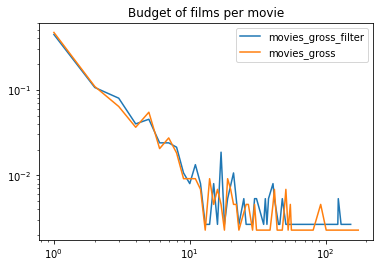

In [428]:
log_vars = True
mvp_budget_utils.plot_budget_validation(df_movies_gross, movies_gross, log_vars)

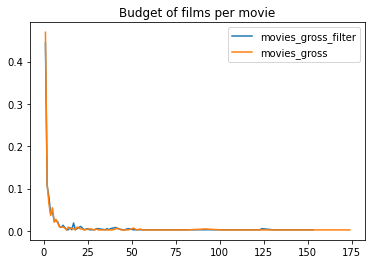

In [429]:
mvp_budget_utils.plot_budget_validation(df_movies_gross, movies_gross, False)

In [430]:
# cuanto representan las peliculas de USA 
(df_movies_gross.country == 'USA').sum() / len(df_movies_gross)

0.7680452093501156

In [431]:
df_usa_budget = df_movies_gross[df_movies_gross.country == 'USA'].copy()

### Analizo si me mueve la aguja tener solo US

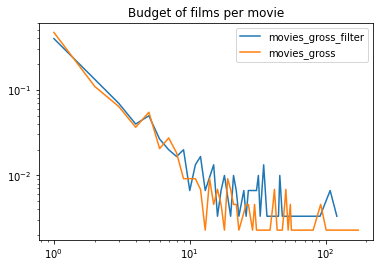

In [432]:
mvp_budget_utils.plot_budget_validation(df_usa_budget, movies_gross)

### Comparo el filtrado vs el real

In [433]:
df_usa_budget[['title_year','budget']].describe()

,title_year,budget
count,2990.000000,2.990000e+03
mean,2005.630769,3.863388e+07
std,6.406294,4.361293e+07
min,1991.000000,2.180000e+02
25%,2001.000000,8.000000e+06
50%,2006.000000,2.500000e+07
75%,2011.000000,5.200000e+07
max,2016.000000,3.000000e+08


In [434]:
movies_gross[['title_year','budget']].describe()

,title_year,budget
count,4935.000000,4.551000e+03
mean,2002.470517,3.975262e+07
std,12.474599,2.061149e+08
min,1916.000000,2.180000e+02
25%,1999.000000,6.000000e+06
50%,2005.000000,2.000000e+07
75%,2011.000000,4.500000e+07
max,2016.000000,1.221550e+10


In [435]:
df_usa_budget.actor_2_name.value_counts()

Morgan Freeman     14
Charlize Theron    11
Brad Pitt          11
Meryl Streep        9
James Franco        9
                   ..
Cameron Mills       1
John Doman          1
Lindsay Price       1
Maxwell Moody       1
Jeremy Davies       1
Name: actor_2_name, Length: 1826, dtype: int64

### Divido el dataset en train, val y test
### y obtengo los siguientes data sets:

X_train, X_val, X_test , lo mismo con la var y

## Comienzo del particionado y explotacion

In [436]:
 X_train, X_val, X_test, y_train, y_val, y_test = mvp_budget_utils.load_budget_train_dev_test(df_movies_gross)

len(X): 3893 len(y): 3893 
len(X_train): 2724, len(X_val): 779, len(X_test):     390 
len(y_train): 2724, len(y_val): 779, len(y_test): 390


In [437]:
# Acá vemos la data de train
X_train[0]

{'director': 'Boris Rodriguez',
 'actor_1_name': 'Stephen McHattie',
 'actor_2_name': 'Thure Lindhardt',
 'actor_3_name': 'Georgina Reilly',
 'genres': ['Comedy', 'Horror'],
 'movie_title': 'Eddie: The Sleepwalking Cannibal\xa0',
 'movie_imdb_link': 'http://www.imdb.com/title/tt1480658/?ref_=fn_tt_tt_1',
 'language': 'English',
 'country': 'Canada',
 'content_rating': 'Not Rated',
 'plot_keywords': ['art teacher',
  'cannibal',
  'inspiration',
  'painter',
  'sleepwalking'],
 'title_year': 2012.0,
 'startYear': 2012.0,
 'duration': 83.0,
 'num_critic_for_reviews': 56.0,
 'director_facebook_likes': 5.0,
 'actor_2_facebook_likes': 197.0,
 'actor_3_facebook_likes': 98.0,
 'actor_1_facebook_likes': 413.0,
 'num_voted_users': 1231,
 'cast_total_facebook_likes': 843,
 'facenumber_in_poster': 0.0,
 'num_user_for_reviews': 10.0,
 'imdb_score': 5.7,
 'tconst': 'tt1480658'}

In [438]:
# miro el budget para el 1er row en train
y_train[10]

7500000.0

In [439]:
X_val[0]
# data.keys()

{'director': 'David Cronenberg',
 'actor_1_name': 'Michael Fassbender',
 'actor_2_name': 'Viggo Mortensen',
 'actor_3_name': 'Sarah Gadon',
 'genres': ['Biography', 'Drama', 'Thriller'],
 'movie_title': 'A Dangerous Method\xa0',
 'movie_imdb_link': 'http://www.imdb.com/title/tt1571222/?ref_=fn_tt_tt_1',
 'language': 'English',
 'country': 'UK',
 'content_rating': 'R',
 'plot_keywords': ['carl jung',
  'patient',
  'psychoanalysis',
  'russian',
  'sigmund freud'],
 'title_year': 2011.0,
 'startYear': 2011.0,
 'duration': 99.0,
 'num_critic_for_reviews': 345.0,
 'director_facebook_likes': 0.0,
 'actor_2_facebook_likes': 10000.0,
 'actor_3_facebook_likes': 691.0,
 'actor_1_facebook_likes': 13000.0,
 'num_voted_users': 80617,
 'cast_total_facebook_likes': 23755,
 'facenumber_in_poster': 3.0,
 'num_user_for_reviews': 190.0,
 'imdb_score': 6.5,
 'tconst': 'tt1571222'}

In [440]:
y_val[0]

15000000.0

## Modelo básico

In [441]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_union, make_pipeline
from sklearn.feature_extraction import DictVectorizer

# import autosklearn.classification
# from autosklearn.metrics import roc_auc

def get_features_pipe(
        use_years: bool, use_genre: bool, 
        use_director: bool, director_kws: dict=None, post_processing=None):
    """
    Construye el pipeline de features de forma parametrizada
    """
    # director_kws solo tiene sentido cuando use_director=True. 
    # Esto nos va a traer dolores de cabeza a la hora de explorar el espacio de hyper parametros
    # TODO: esto debería permitir cachear los datasets transformados
    
    steps = []
    if use_years:
        steps.append(make_pipeline(transformers.YearsAgo(), DictVectorizer(sparse=False)))
    
    if use_genre:
        steps.append(make_pipeline(transformers.GenreDummies(), DictVectorizer(sparse=False)))
        
    if use_director:
        director_kws = director_kws or {}
        # cuando hacemos **director_kws usamos ese diccionario para pasar parametros
        steps.append(make_pipeline(DirectorFeatures(**director_kws), DictVectorizer(sparse=False)))
    
    res = make_union(*steps)
    if post_processing:
        res = make_pipeline(res, post_processing)
    return res

def get_model_pipe(features_pipe, estimator):
    return make_pipeline(features_pipe, estimator)

In [449]:
# Creamos modelo
model = get_model_pipe(
    features_pipe=get_features_pipe(
        use_years=False, use_director=False, use_genre=True, post_processing=StandardScaler()
    ),
    estimator=LinearRegression()   
)

# model

In [447]:
len(model)

2

In [448]:
model.fit(X_train, y_train)

IndexError: Too many levels: Index has only 1 level, not 2

In [445]:
y_pred = model.predict(X_val)
# print('accuracy: ', accuracy_score(y_val, y_pred), 'f1_score: ', f1_score(y_val, y_pred, average = 'weighted'))

MSE = np.square(np.subtract(y_val,y_pred)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)


Root Mean Square Error:

102366214.05978513


## Random Forest

In [379]:
import copy
import random

from scipy.stats import uniform
from scipy.stats import randint
from sklearn.pipeline import Pipeline,TransformerMixin
from sklearn.base import BaseEstimator

from sklearn.metrics import mean_squared_error, r2_score,make_scorer
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.svm import LinearSVR

from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor #use RandomForestRegressor for regression problem
from sklearn.ensemble import GradientBoostingRegressor #For Regression
from sklearn import tree


from sklearn.decomposition import PCA, NMF

# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
# from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold,GroupKFold,KFold
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import ensemble

#from sklearn.externals 
import joblib


In [276]:
# dividimos el ds en train, val y test
def load_budget_train_dev_test(df):

    X = df.loc[:,'title_year':'tconst'] #me quedo con train solo
#     X = df.loc[ : , df.columns != 'budget'] #me quedo con train solo
    y = df["budget"]  #var target y
    
    # Split en 80:20, esto es train y val
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=101)

    # AHora con el 0.875, tengo mi test, y finalmente me queda 70,20,10   (ver que 0.8 * 0.875 = 0.7)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.875, random_state=101)

    print("len(X): {} len(y): {} \nlen(X_train): {}, len(X_val): {}, len(X_test): \
    {} \nlen(y_train): {}, len(y_val): {}, len(y_test): {}".format(len(X), len(y),\
    len(X_train), len(X_val), len(X_test), len(y_train), len(y_val), \
    len(y_test))) 
    
#     return X_train.to_dict(orient='records'), X_val.to_dict(orient='records'), X_test.to_dict(orient='records'), y_train, y_val, y_test
    return X_train, X_val, X_test, y_train, y_val, y_test

In [277]:
# Filtro columnas del df movie_gross y me quedo con las que pueden servir
df_movies_budget = movies_gross[['director', 'actor_1_name','actor_2_name', 'actor_3_name', 'genres', 'movie_title', 'movie_imdb_link', 'language', 'country', 'content_rating',
                                 'title_year', 'startYear', 'duration', 'num_critic_for_reviews', 'director_facebook_likes', 'actor_2_facebook_likes', 
                                 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes','facenumber_in_poster', 
                                 'num_user_for_reviews', 'imdb_score', 'tconst', 'budget']]
df_movies_budget.head(2)

,director,actor_1_name,actor_2_name,actor_3_name,genres,movie_title,movie_imdb_link,language,country,content_rating,title_year,startYear,duration,num_critic_for_reviews,director_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,tconst,budget
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action|Adventure|Fantasy|Sci-Fi,Avatar,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,English,USA,PG-13,2009.0,2009.0,178.0,723.0,0.0,936.0,855.0,1000.0,886204,4834,0.0,3054.0,7.9,tt0499549,237000000.0
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,English,USA,PG-13,2007.0,2007.0,169.0,302.0,563.0,5000.0,1000.0,40000.0,471220,48350,0.0,1238.0,7.1,tt0449088,300000000.0


In [278]:
 X_train, X_val, X_test, y_train, y_val, y_test = load_budget_train_dev_test(df_movies_budget)

len(X): 5043 len(y): 5043 
len(X_train): 3529, len(X_val): 1009, len(X_test):     505 
len(y_train): 3529, len(y_val): 1009, len(y_test): 505


In [279]:
X_train.head(2)

,title_year,startYear,duration,num_critic_for_reviews,director_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,tconst
4003,1987.0,1987.0,37.0,252.0,0.0,328.0,199.0,634.0,113451,1347,0.0,537.0,7.8,tt0092991
1053,2014.0,2014.0,115.0,222.0,118.0,794.0,482.0,14000.0,133436,16967,0.0,323.0,6.0,tt2446042


In [280]:
y_test.head(2)

3229           NaN
941     70000000.0
Name: budget, dtype: float64

In [392]:
#   train_models(pipe,     params, X_p2_7,y_p2_7, X_pred_p2_7, y_pred_p2_7, vars_target, str(pipe_label+'_7_days_p2'))
def train_models(pipeline, params, X,      y,     X_test,      y_test,       vars_target, pipe_label):

    # me quedo solo con las numericas
#     df_movies_budget.iloc[:,10:-2].head(2)
    X_test_= copy.deepcopy(X_test.loc[:,'title_year':'imdb_score'])

    #Params RS
    rs = RandomizedSearchCV(pipeline, param_distributions=params, refit=True,
                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1, n_iter=10,random_state=42, verbose=0)
    d = []
#         rs.fit(X.iloc[:,5:-4].values, y[i].values)
    rs.fit(X.loc[:,'title_year':'imdb_score'].values, y.values)
    rs_model= rs.best_estimator_

    d.append({'pipe_label': pipe_label, 'target': vars_target[0], 'best_score_train': rs.best_score_,
              'best_score_test': rs_model.score(X_test_, y_test),

              'rmse_train': np.sqrt(mean_squared_error(y.values, rs_model.predict(X.loc[:,'title_year':'imdb_score'].values))),

              'rmse_test': np.sqrt(mean_squared_error(y_test.values, rs_model.predict(X_test_.values)))
             })
    joblib.dump(rs_model, '../../model_output/'+vars_target[0]+'_'+pipe_label+'_.pkl')

    out = pd.DataFrame(d)
    out[['pipe_label','target', 'best_score_train', 'best_score_test', 'rmse_train', 'rmse_test' ]].to_csv('../../prediction_output/results.csv', mode='a', header=True, index=False)

    return out

In [282]:
class IdentityTransformer(BaseEstimator,TransformerMixin):
    def transform(self, X, **transform_params):
        return X
    def fit(self, X, y=None, **fit_params):
        return self

In [382]:
def define_pipes():
    # creo estimadores para transformar data (2nd features)
    pipe1 = Pipeline([
            ('Pipe_StandardScaler', FeatureUnion([
                                    ('media', StandardScaler())
                                    ],n_jobs=-1)),
            ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse',
                                                            n_jobs=-1,oob_score = 'TRUE', random_state=42, verbose=0 ))
            ])

    pipe2 = Pipeline([
            ('Pipe_MinMaxScaler', FeatureUnion([
                                    ('range',MinMaxScaler()),
                                    ],n_jobs=-1)),
            ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse',
                                                            n_jobs=-1,oob_score = 'TRUE', random_state=42 ))
            ])
    
    pipe3 = Pipeline([
            ('IdentityTransformer', FeatureUnion([
                                    ('in', IdentityTransformer()),
                                    ],n_jobs=-1)),
            ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse',
                                                            n_jobs=-1,oob_score = 'TRUE', random_state=42 ))
            ])

    pipe4 = Pipeline([
            ('superPipe', FeatureUnion([
                                    ('in', IdentityTransformer()),
                                    ('pca', PCA(n_components=2)),
                                    ('nmf', NMF(init='random')),
                                    ("univ_select", SelectKBest(k=1)),
                                    ('range',MinMaxScaler()),
                                    ('media', StandardScaler())
                                    ],n_jobs=-1)),
            ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse',
                                                            n_jobs=-1,oob_score = 'TRUE', random_state=42 ))
            ])

    pipe5 = Pipeline([
            ('superPipe2', FeatureUnion([
                                    ('in', IdentityTransformer()),
                                    ('pca', PCA(n_components=2)),
                                    ('nmf', NMF(init='random')),
                                    ("univ_select", SelectKBest(k=1)),
                                    ('range',MinMaxScaler()),
                                    ('media', StandardScaler())
                                    ],n_jobs=-1)),
            ('feature_selection', SelectFromModel(LinearSVR(), threshold=None)),
            ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse',
                                                            n_jobs=-1,oob_score = 'TRUE', random_state=42 ))
            ])
    
    # params estimators+alg
    params = {
        
        # RandomForestRegressor params (si usáramos GridSearch)
        
#         'RandomForestRegressor__max_features': ('log2', 'sqrt', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6),
#         'RandomForestRegressor__n_estimators': random.sample(range(100, 1000), 100),
#         'RandomForestRegressor__max_depth': range(1, 20),
#         'RandomForestRegressor__min_samples_leaf':range(1, 20),
#         'RandomForestRegressor__min_samples_split':range(1, 20)
        
        # Para aprovechar el poder de RandomizedSearchCV, en lugar de pasarle parámetros fijos, 
        # se le pasan distribuciones de las cuales tomar los parámetros. Esa es la principal 
        # diferencia con GridSearch. 
        
        
        
        'RandomForestRegressor__max_features': ('log2', 'sqrt', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6),
        'RandomForestRegressor__n_estimators': randint(100, 1000),
        'RandomForestRegressor__max_depth': randint(1,20),
        'RandomForestRegressor__min_samples_leaf': randint(1,20),
        'RandomForestRegressor__min_samples_split':randint(1,20)
        
    }
    # params2 = {
    # #     'nmf__n_components': ([2]),
    # #     'nmf__tol': (0.001),
    #     # RandomForestRegressor params
    #     'RandomForestRegressor__max_features': ('log2', 'sqrt', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6),
    #     'RandomForestRegressor__n_estimators': random.sample(range(100, 1000), 100),
    #     'RandomForestRegressor__max_depth': range(1, 20),
    #     'RandomForestRegressor__min_samples_leaf':range(1, 20),
    #     'RandomForestRegressor__min_samples_split':range(1, 20)
    # }
    return pipe1, pipe2, pipe3, pipe4, pipe5, params

In [383]:
pipe1,pipe2, pipe3,pipe4, pipe5, params = define_pipes()
# label="1_Random_Forest_completo_StandardScaler"
output={}


## Separo en train, validation y en test
veo que tenemos problemas con budget .. esta en nan .. los filtramos?? les imputamos la media?

#### Replace using median 

median = df['budget'].median()

df['budget'].fillna(median, inplace=True)


### Replace dropping null values
df_movies_budget.dropna(subset=['budget'])

In [384]:
df_movies_budget.head(2)

,director,actor_1_name,actor_2_name,actor_3_name,genres,movie_title,movie_imdb_link,language,country,content_rating,title_year,startYear,duration,num_critic_for_reviews,director_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,tconst,budget
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action|Adventure|Fantasy|Sci-Fi,Avatar,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,English,USA,PG-13,2009.0,2009.0,178.0,723.0,0.0,936.0,855.0,1000.0,886204,4834,0.0,3054.0,7.9,tt0499549,237000000.0
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,English,USA,PG-13,2007.0,2007.0,169.0,302.0,563.0,5000.0,1000.0,40000.0,471220,48350,0.0,1238.0,7.1,tt0449088,300000000.0


# Estoy filtrando los nan y los inf

In [385]:
# df_movies_budget.dropna(subset=['budget'])
# ds_filter = copy.deepcopy(df_movies_budget[~df_movies_budget.isin([np.nan, np.inf, -np.inf])])
ds_filter = copy.deepcopy(df_movies_budget)

ds_filter[ds_filter==np.inf]=np.nan
ds_filter.fillna(ds_filter.mean(), inplace=True)
# TODO falta sacar series y novelas y chinos

X_train, X_val, X_test, y_train, y_val, y_test = load_budget_train_dev_test(ds_filter)

len(X): 5043 len(y): 5043 
len(X_train): 3529, len(X_val): 1009, len(X_test):     505 
len(y_train): 3529, len(y_val): 1009, len(y_test): 505


In [386]:
X_train.head(2)

,title_year,startYear,duration,num_critic_for_reviews,director_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,tconst
4003,1987.0,1987.0,37.0,252.0,0.0,328.0,199.0,634.0,113451,1347,0.0,537.0,7.8,tt0092991
1053,2014.0,2014.0,115.0,222.0,118.0,794.0,482.0,14000.0,133436,16967,0.0,323.0,6.0,tt2446042


# Buscamos peliculas con budget extraños

In [387]:
y_train[~y_train.isin([np.nan, np.inf, -np.inf])].sort_values(ascending=[False])

2988    1.221550e+10
3859    4.200000e+09
3005    2.500000e+09
2323    2.400000e+09
2334    2.127520e+09
            ...     
5035    7.000000e+03
5026    4.500000e+03
5036    3.250000e+03
5040    1.400000e+03
5042    1.100000e+03
Name: budget, Length: 3529, dtype: float64

In [388]:
df_movies_budget.iloc[2334]

director                                                          Katsuhiro Ôtomo
actor_1_name                                                     William Hootkins
actor_2_name                                                   Robin Atkin Downes
actor_3_name                                                       Rosalind Ayres
genres                          Action|Adventure|Animation|Family|Sci-Fi|Thriller
movie_title                                                             Steamboy 
movie_imdb_link              http://www.imdb.com/title/tt0348121/?ref_=fn_tt_tt_1
language                                                                 Japanese
country                                                                     Japan
content_rating                                                              PG-13
title_year                                                                   2004
startYear                                                                    2004
duration        

In [389]:
# Chequeo si tengo faltantes en budget
df_movies_budget.isnull().any()

director                      True
actor_1_name                  True
actor_2_name                  True
actor_3_name                  True
genres                       False
movie_title                  False
movie_imdb_link              False
language                      True
country                       True
content_rating                True
title_year                    True
startYear                     True
duration                      True
num_critic_for_reviews        True
director_facebook_likes       True
actor_2_facebook_likes        True
actor_3_facebook_likes        True
actor_1_facebook_likes        True
num_voted_users              False
cast_total_facebook_likes    False
facenumber_in_poster          True
num_user_for_reviews          True
imdb_score                   False
tconst                       False
budget                        True
dtype: bool

In [390]:
for pipe in (pipe1,pipe2, pipe3,pipe4, pipe5):
    print("pipelabel: ",str(pipe.steps[0][0]), "\n",pipe.named_steps,"\n")
    pipe_label=str(pipe.steps[0][0]) #get name pipe

    if repr(pipe_label) ==repr('superPipe') or repr(pipe_label) ==repr('superPipe2'):
        print('\npipe_label : ',pipe_label,'\n')
    output =train_models(pipe, params,  X_train, y_train, X_val, y_val, ["budget"], str(pipe_label+'_budget_pred'))

pipelabel:  Pipe_StandardScaler 
 {'Pipe_StandardScaler': FeatureUnion(n_jobs=-1, transformer_list=[('media', StandardScaler())]), 'RandomForestRegressor': RandomForestRegressor(n_jobs=-1, oob_score='TRUE', random_state=42)} 

pipelabel:  Pipe_MinMaxScaler 
 {'Pipe_MinMaxScaler': FeatureUnion(n_jobs=-1, transformer_list=[('range', MinMaxScaler())]), 'RandomForestRegressor': RandomForestRegressor(n_jobs=-1, oob_score='TRUE', random_state=42)} 

pipelabel:  IdentityTransformer 
 {'IdentityTransformer': FeatureUnion(n_jobs=-1, transformer_list=[('in', IdentityTransformer())]), 'RandomForestRegressor': RandomForestRegressor(n_jobs=-1, oob_score='TRUE', random_state=42)} 

pipelabel:  superPipe 
 {'superPipe': FeatureUnion(n_jobs=-1,
             transformer_list=[('in', IdentityTransformer()),
                               ('pca', PCA(n_components=2)),
                               ('nmf', NMF(init='random')),
                               ('univ_select', SelectKBest(k=1)),
            

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Miramos cual es el mejor modelo

In [391]:
df = pd.read_csv('../../prediction_output/results.csv')
df.columns = ['pipe_label','target', 'best_score_train', 'best_score_test', 'rmse_train', 'rmse_test' ]
df.to_csv('../../prediction_output/results.csv')

## Con los pkl predigo

In [393]:
output=copy.deepcopy(ds_filter)

In [394]:
output.head(2)

,director,actor_1_name,actor_2_name,actor_3_name,genres,movie_title,movie_imdb_link,language,country,content_rating,title_year,startYear,duration,num_critic_for_reviews,director_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,tconst,budget
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action|Adventure|Fantasy|Sci-Fi,Avatar,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,English,USA,PG-13,2009.0,2009.0,178.0,723.0,0.0,936.0,855.0,1000.0,886204,4834,0.0,3054.0,7.9,tt0499549,237000000.0
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,English,USA,PG-13,2007.0,2007.0,169.0,302.0,563.0,5000.0,1000.0,40000.0,471220,48350,0.0,1238.0,7.1,tt0449088,300000000.0


In [395]:
# Uso los pkl
loaded_model1  = joblib.load('../../model_output/budget_superPipe2_budget_pred_.pkl')

In [396]:
# output['budget_pred'] = loaded_model1.predict(X_test.values)  # este no lo usen
output['budget_pred'] = loaded_model1.predict(ds_filter.loc[:,'title_year':'imdb_score'])  # este es el entregable
output[['tconst', 'budget','budget_pred']].to_csv("../../prediction_output/"+"budget"+"_salida.csv")

In [400]:
print('R2 score: ', r2_score(output['budget'],output['budget_pred']))

R2 score:  0.019305682796983525


In [397]:
## buscar el 
print("../../prediction_output/"+"budget"+"_salida.csv")

../../prediction_output/budget_salida.csv
